# Bankmarketing - Prognose von Festgeldabschlüssen
Dieses Projekt analysiert Marketingdaten einer portugiesischen Bank, um vorherzusagen, ob ein Kunde ein Festgeld abschließen wird. Verschiedene Modelle werden basierend auf dem F1-Score evaluiert und verglichen.

### 0. Setup

In [1]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score

### 1. Daten laden

In [2]:
#pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# Datensatz abrufen 
bank_marketing = fetch_ucirepo(id=222) 
  
# Daten als pandas dataframes
features = bank_marketing.data.features 
target = bank_marketing.data.targets 
  
# Metadaten
print(bank_marketing.metadata) 
  
# Variablen 
print(bank_marketing.variables) 

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [4]:
# Features und Zielvariable zusammenfügen
df = pd.concat([features, target], axis=1)

### 2. Explorative Datenanalyse

In [5]:
# Visualisierungsstil setzen
sns.set_palette("Set2")
sns.set_style("whitegrid")

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


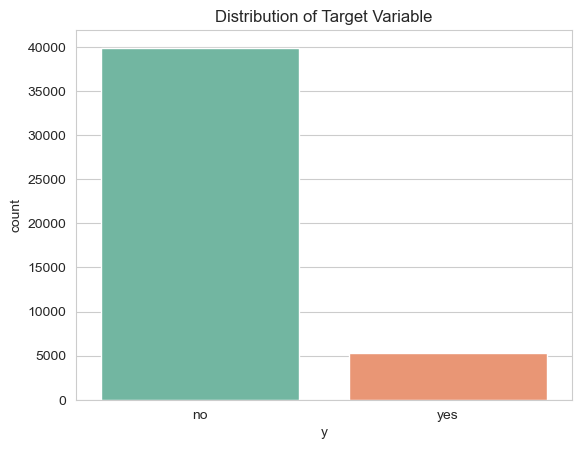

In [6]:
# Zielvariable analysieren
print(df['y'].value_counts(normalize=True))
sns.countplot(data=df, x='y')
plt.title('Distribution of Target Variable')
plt.show()

Der Datensatz ist deutlich unausgeglichen, da wesentlich weniger Beispiele der Zielkategorie 1 zugeordnet sind.

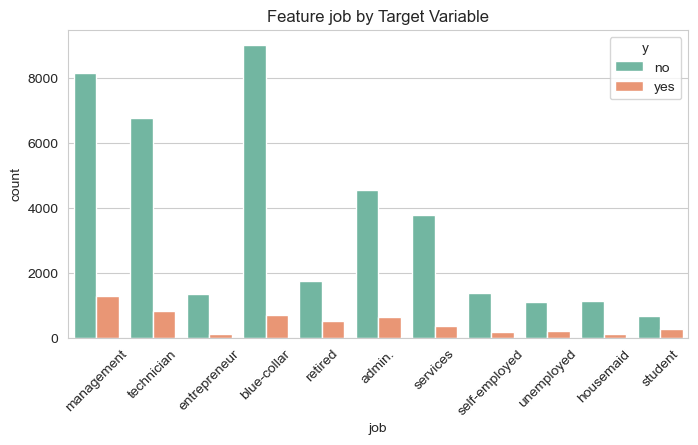

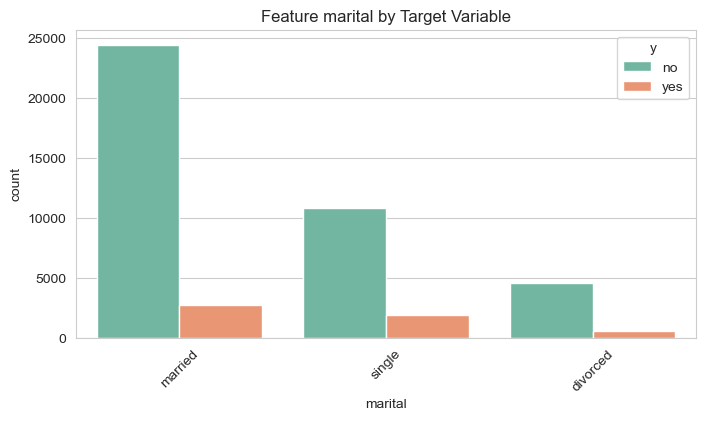

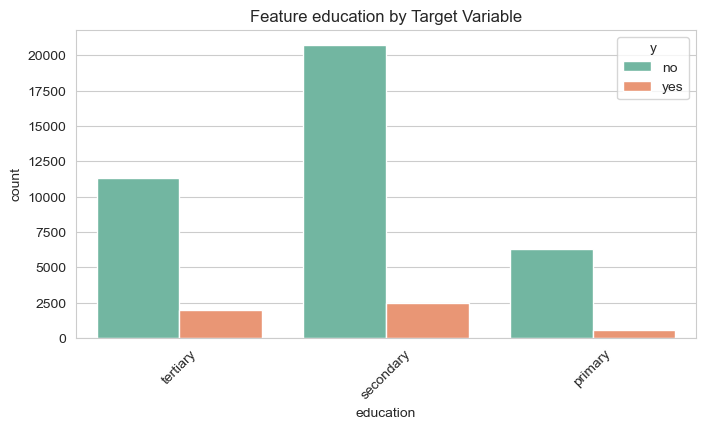

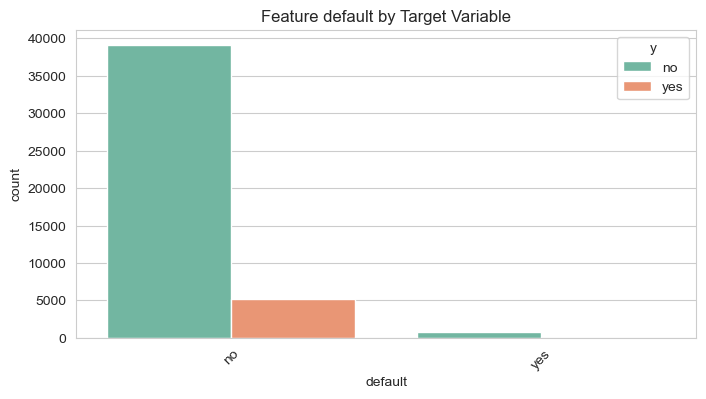

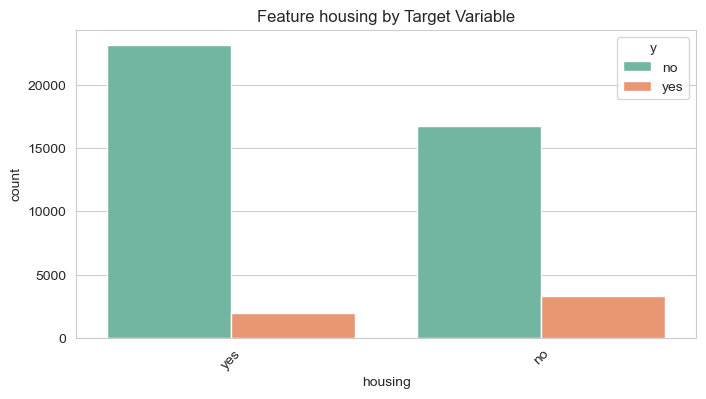

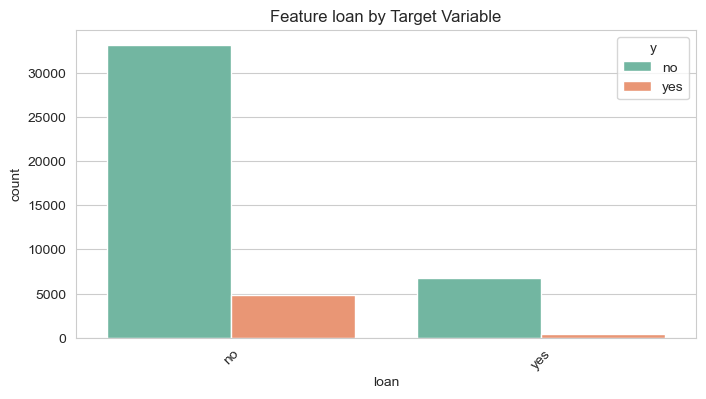

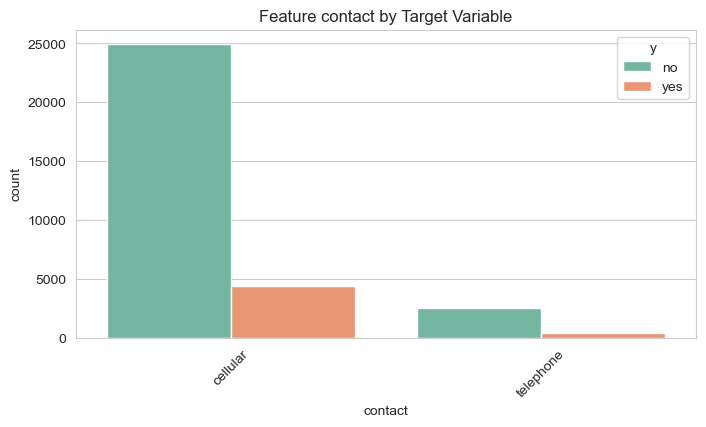

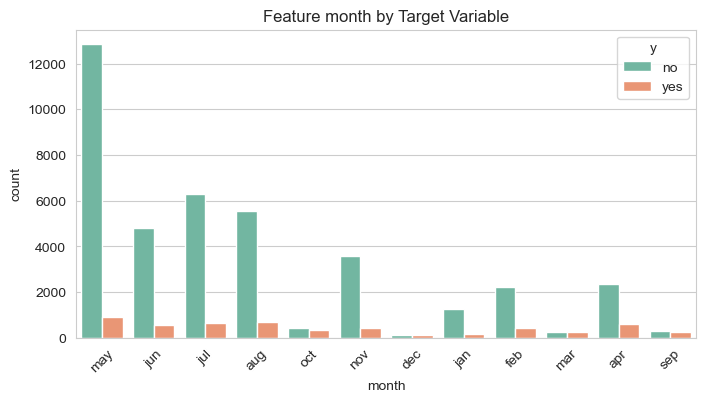

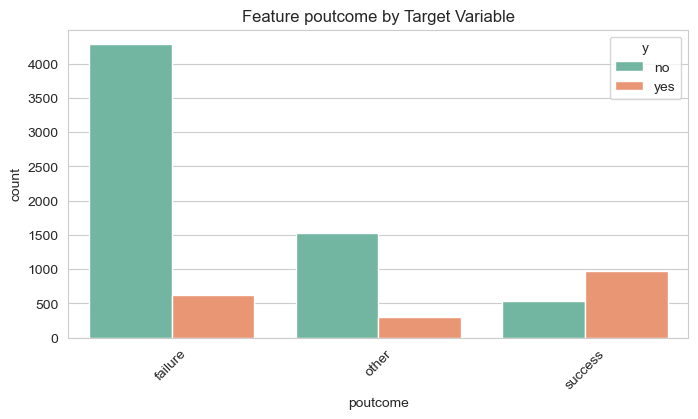

In [7]:
# Überblick über kategoriale Merkmale
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('y')

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'Feature {col} by Target Variable')
    plt.xticks(rotation=45)
    plt.show()

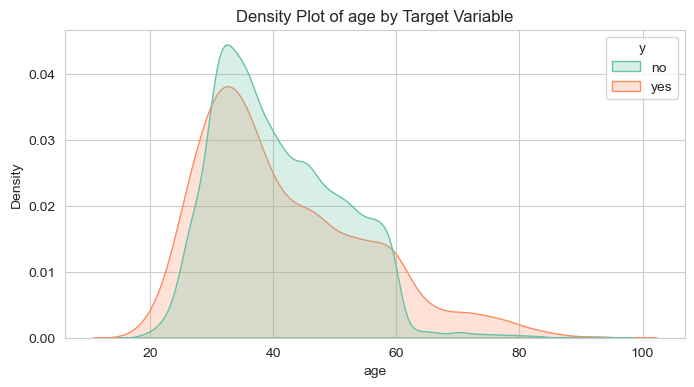

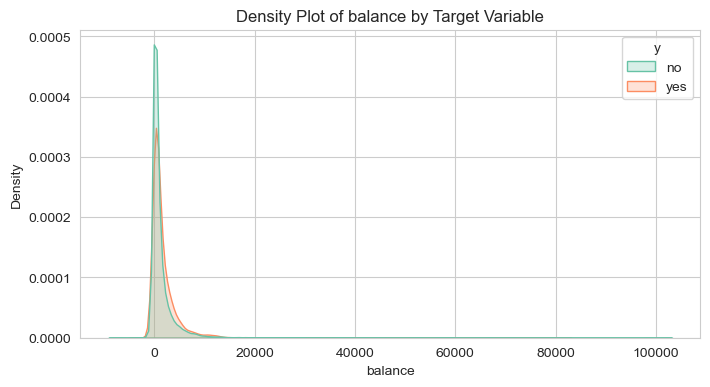

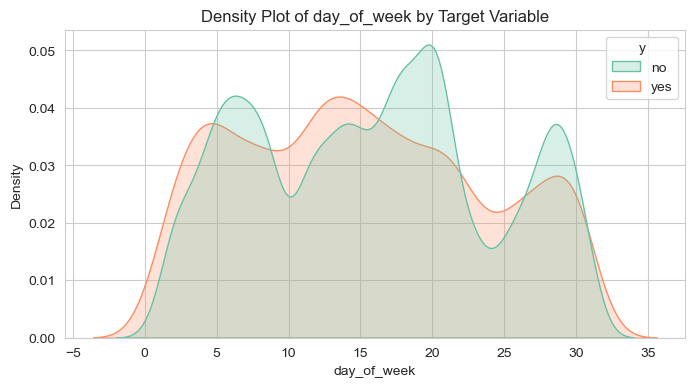

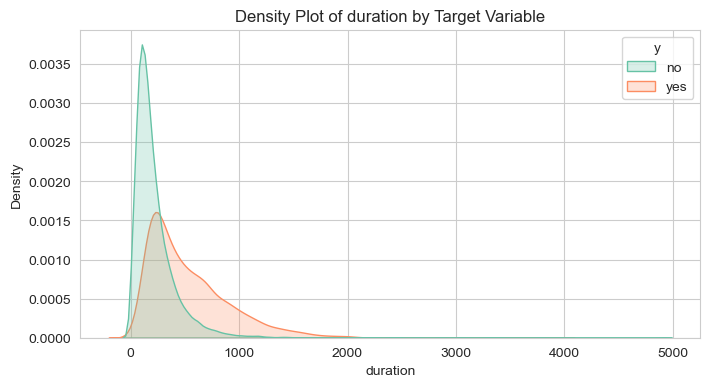

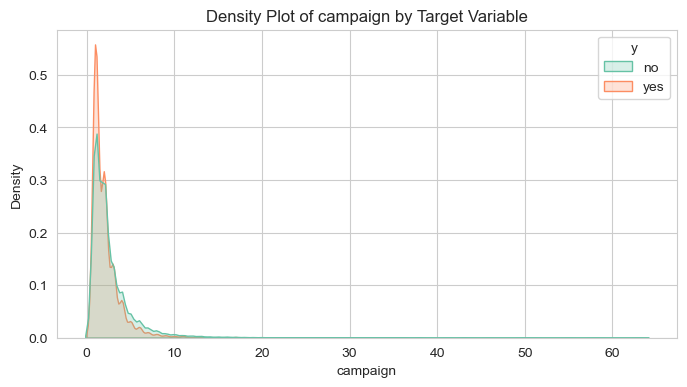

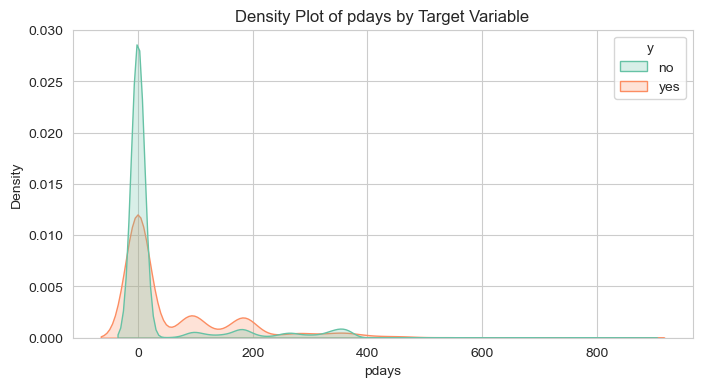

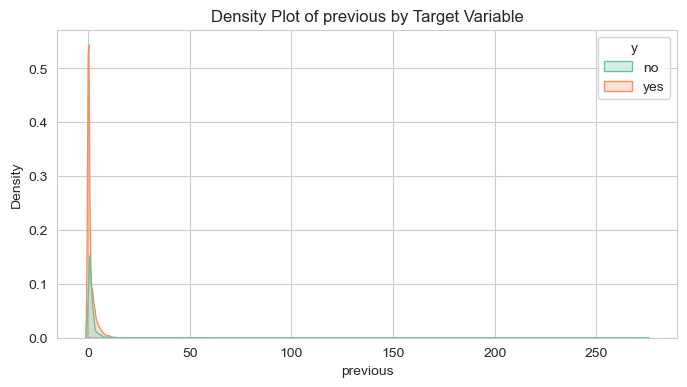

In [8]:
# Überblick über numerische Merkmale
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=col, hue='y', common_norm=False, fill=True)
    plt.title(f'Density Plot of {col} by Target Variable')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()


Bei der visuellen Analyse wurden keine signifikanten Ausreißer festgestellt.

In [9]:
# Fehlende Werte in Prozent anzeigen
missing_percentages = df.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0]
print(missing_percentages.sort_values(ascending=False))

poutcome     81.747805
contact      28.798301
education     4.107407
job           0.637013
dtype: float64


Es gibt einige fehlende Werte, insbesondere in der vielversprechenden Variable 'poutcome', die möglicherweise behandelt werden müssen.

### 3. Feature Cleaning und Engineering

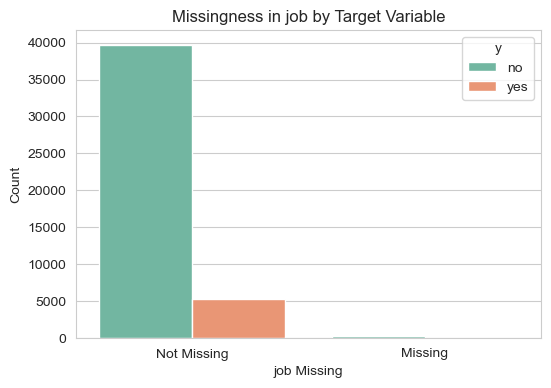

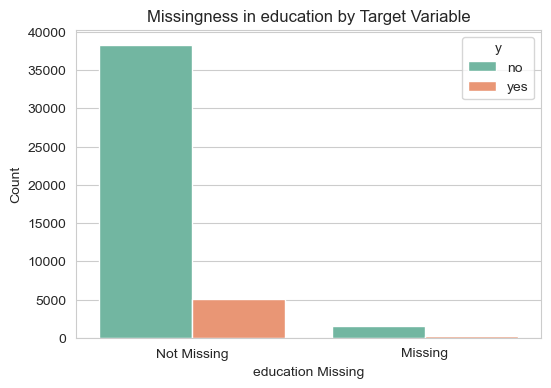

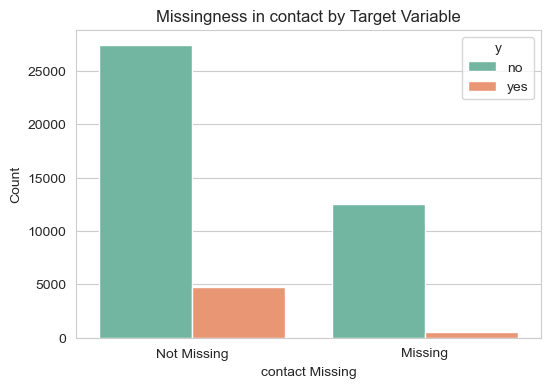

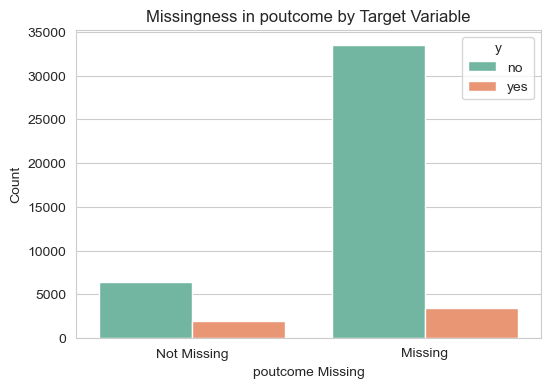

In [10]:
# Spalten mit fehlenden Werten finden
missing_cols = df.columns[df.isnull().any()]

# Fehlende Werte visualisieren
for col in missing_cols:
    plt.figure(figsize=(6, 4))
    
    temp_missing = df[col].isnull().astype(int)
    
    sns.countplot(x=temp_missing, hue=df['y'])
    plt.title(f'Missingness in {col} by Target Variable')
    plt.xticks([0, 1], ['Not Missing', 'Missing'])
    plt.xlabel(f'{col} Missing')
    plt.ylabel('Count')
    plt.legend(title='y')
    plt.show()


Da alle fehlenden Werte in kategorialen Variablen auftreten, füllen wir die fehlenden Werte durch eine neue Kategorie 'unknown' auf.

In [11]:
# Fehlende Werte auffüllen
for col in missing_cols:
    df[col] = df[col].fillna('unknown')

In [12]:
# Neue features erstellen

# Wurde der Kunde zuvor kontaktiert?
df['was_previously_contacted'] = df['pdays'].apply(lambda x: 'yes' if x != -1 else 'no')
 
# Kontakt in erster Monatshälfte
df['first_half_month'] = df['day_of_week'].apply(lambda x: 'yes' if x <= 15 else 'no')

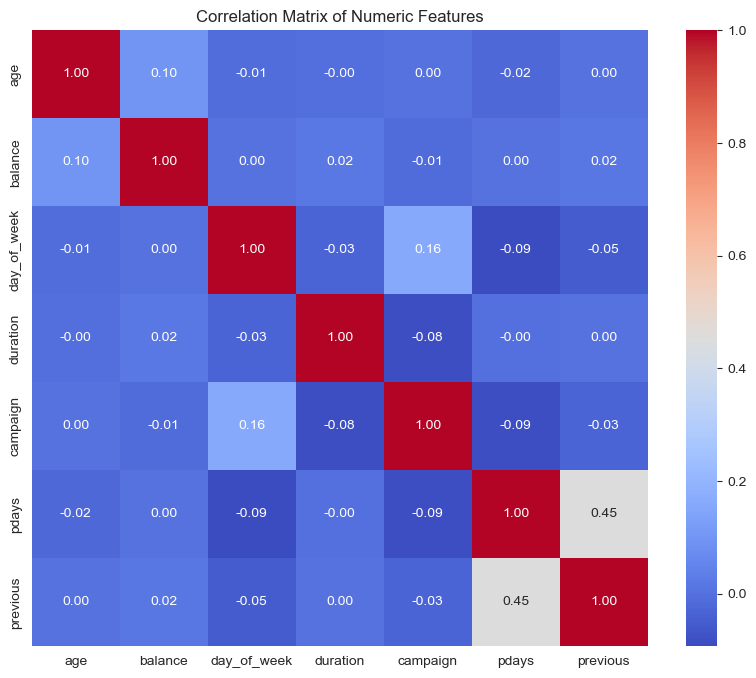

In [13]:
# Korrelationsmatrix der numerischen Features
corr_matrix = df[numerical_cols].corr()

# Heatmap der Korrelation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


Starke Korrelationen zwischen Variablen wurden nicht festgestellt.  
Bei Decision Tree basierten Modellen wie Random Forest und Gradient Boosting ist die Berücksichtigung korrelierter Features weniger kritisch, da diese Modelle robust gegenüber Multikollinearität sind.  
Für lineare Modelle wie die logistische Regression sollte eine hohe Korrelation jedoch beachtet werden, da sie dort die Modellstabilität beeinträchtigen kann.

### 4. Train-Test Split

In [14]:
# Features (X) und Zielvariable (y) definieren
X = df.drop('y', axis=1)
y = df['y']

Da der Datensatz hinsichtlich der positiven Klasse unausgeglichen ist, wird beim Train-Test-Split eine Stratifizierung verwendet, um die Verteilung der Zielvariable in beiden Datensätzen beizubehalten.

In [15]:
# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15, stratify=y
)

### 5. Datenvorverarbeitung (Kodierung und Skalierung)

In [16]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()

# Numerische Variablen skalieren
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


Hinweis: Die Skalierung der numerischen Variablen ist insbesondere für die logistische Regression relevant, da sie auf der Optimierung von Gewichten basiert.  
Für baumbasierte Modelle wie Random Forest oder Gradient Boosting ist eine Skalierung hingegen nicht erforderlich.

In [17]:
# Binäre 'yes'/'no'-Variablen in 1/0 umwandeln
binary_cols = ['default', 'housing', 'loan', 'first_half_month', 'was_previously_contacted']
for col in binary_cols:
    X_train[col] = X_train[col].map({'yes': 1, 'no': 0})
    X_test[col] = X_test[col].map({'yes': 1, 'no': 0})

# Zielvariable ebenfalls umwandeln
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})

Die ordinale Kodierung der Variable 'education' ist sinnvoll, da sie die natürliche Rangfolge der Bildungsabschlüsse beibehält.  

In [18]:
# Ordinale Kodierung der Ausbildung
education_mapping = {
    'primary': 0,
    'secondary': 1,
    'tertiary': 2,
    'unknown': -1  
}

X_train['education'] = X_train['education'].map(education_mapping)
X_test['education'] = X_test['education'].map(education_mapping)

Alle anderen kategorialen Variablen wurden mittels One-Hot-Encoding in Dummy-Variablen umgewandelt.


In [19]:
# One-Hot-Encoding der restlichen kategorialen Merkmale
categoric_cols = X_train.select_dtypes(include='object').columns.tolist()

X_train = pd.get_dummies(X_train, columns=categoric_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categoric_cols, drop_first=True)

# Trainings- und Testdaten angleichen
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


### 6. Modellierung

Zunächst wird mit einem einfachen Baseline-Modell gestartet, um eine erste Leistungsbewertung zu erhalten.
Anschließend werden weitere Modelle ausprobiert, um die Vorhersagequalität zu verbessern.

#### Logistic Regression (baseline)

In [20]:
# Modell definieren
logreg = LogisticRegression(random_state=42)

# Cross-Validation auf Trainingsdaten (F1-Score)
logreg_cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1')

print(f"Mittlerer F1-Score der logistischen Regression (5-fach CV): {logreg_cv_scores.mean():.4f}")

# Modell auf den gesamten Trainingsdaten neu trainieren
logreg.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_logreg = logreg.predict(X_test)
y_pred_proba_logreg = logreg.predict_proba(X_test)[:, 1]

# Bewertung auf Testdaten
print("Klassifikationsbericht Logistische Regression (Testdaten):")
print(classification_report(y_test, y_pred_logreg))

print(f"ROC-AUC-Score auf Testdaten: {roc_auc_score(y_test, y_pred_proba_logreg):.4f}")


c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mittlerer F1-Score der logistischen Regression (5-fach CV): 0.4531
Klassifikationsbericht Logistische Regression (Testdaten):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.67      0.35      0.46      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043

ROC-AUC-Score auf Testdaten: 0.9065


c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

#### Random Forest

In [21]:
# Basismodell definieren
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Cross-Validation auf Trainingsdaten (F1-Score)
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')

print(f"Mittlerer F1-Score Random Forest (5-fach CV): {rf_cv_scores.mean():.4f}")

# Modell auf den gesamten Trainingsdaten neu trainieren
rf.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Bewertung auf Testdaten
print("Klassifikationsbericht Random Forest (Testdaten):")
print(classification_report(y_test, y_pred_rf))

print(f"ROC-AUC-Score auf Testdaten: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

Mittlerer F1-Score Random Forest (5-fach CV): 0.4891
Klassifikationsbericht Random Forest (Testdaten):
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.67      0.40      0.50      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.69      0.72      9043
weighted avg       0.89      0.91      0.90      9043

ROC-AUC-Score auf Testdaten: 0.9349


In [22]:
# Optimiertes Random Forest Modell definieren
rf2 = RandomForestClassifier(
    n_estimators=300, 
    random_state=42, 
    n_jobs=-1, 
    class_weight='balanced', 
    criterion='entropy', 
    min_samples_split=5
)

# Cross-Validation auf Trainingsdaten (F1-Score)
rf2_cv_scores = cross_val_score(rf2, X_train, y_train, cv=5, scoring='f1')

print(f"Mittlerer F1-Score Optimierter Random Forest (5-fach CV): {rf2_cv_scores.mean():.4f}")

# Modell auf den gesamten Trainingsdaten neu trainieren
rf2.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_rf2 = rf2.predict(X_test)
y_pred_proba_rf2 = rf2.predict_proba(X_test)[:, 1]

# Bewertung auf Testdaten
print("Klassifikationsbericht Optimierter Random Forest (Testdaten):")
print(classification_report(y_test, y_pred_rf2))

print(f"ROC-AUC-Score auf Testdaten: {roc_auc_score(y_test, y_pred_proba_rf2):.4f}")


Mittlerer F1-Score Optimierter Random Forest (5-fach CV): 0.5610
Klassifikationsbericht Optimierter Random Forest (Testdaten):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7985
           1       0.63      0.54      0.58      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.75      0.77      9043
weighted avg       0.90      0.91      0.91      9043

ROC-AUC-Score auf Testdaten: 0.9371


#### Gradient Boosting

In [23]:
# Basismodell für Grid Search definieren
gb_base = GradientBoostingClassifier(random_state=42)

# Kleines Hyperparameter-Raster für Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5, 7]
}

# Grid Search Setup
grid_search_gb = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Grid Search ausführen
grid_search_gb.fit(X_train, y_train)

# Beste Parameter und Ergebnisse
print("Beste Parameter für Gradient Boosting:", grid_search_gb.best_params_)
print(f"Bester F1-Score während Cross-Validation: {grid_search_gb.best_score_:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Beste Parameter für Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
Bester F1-Score während Cross-Validation: 0.5415


In [24]:
# Finales Gradient Boosting Modell definieren
gb = GradientBoostingClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=7, 
    random_state=42
)

# Cross-Validation auf Trainingsdaten (F1-Score)
gb_cv_scores = cross_val_score(gb, X_train, y_train, cv=5, scoring='f1')

print(f"Mittlerer F1-Score Gradient Boosting (5-fach CV): {gb_cv_scores.mean():.4f}")

# Modell auf den gesamten Trainingsdaten neu trainieren
gb.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]

# Bewertung auf Testdaten
print("Klassifikationsbericht Gradient Boosting (Testdaten):")
print(classification_report(y_test, y_pred_gb))

print(f"ROC-AUC-Score auf Testdaten: {roc_auc_score(y_test, y_pred_proba_gb):.4f}")


Mittlerer F1-Score Gradient Boosting (5-fach CV): 0.5500
Klassifikationsbericht Gradient Boosting (Testdaten):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7985
           1       0.64      0.50      0.56      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.73      0.76      9043
weighted avg       0.90      0.91      0.90      9043

ROC-AUC-Score auf Testdaten: 0.9356


### 7. Ergebnisse

In [25]:
# Dictionary erstellen, um die Ergebnisse der Modelle zu speichern
model_results = {
    "Modell": [],
    "F1-Score (Positive Klasse)": [],
    "Accuracy": [],
    "Recall (Positive Klasse)": [],
    "Precision (Positive Klasse)": [],
    "ROC-AUC": []
}

# Ergebnisse für Random Forest (optimiert) hinzufügen
model_results["Modell"].append("Random Forest (optimiert)")
model_results["F1-Score (Positive Klasse)"].append(f1_score(y_test, y_pred_rf2, pos_label=1))
model_results["Accuracy"].append(accuracy_score(y_test, y_pred_rf2))
model_results["Recall (Positive Klasse)"].append(recall_score(y_test, y_pred_rf2, pos_label=1))
model_results["Precision (Positive Klasse)"].append(precision_score(y_test, y_pred_rf2, pos_label=1))
model_results["ROC-AUC"].append(roc_auc_score(y_test, y_pred_proba_rf2))

# Ergebnisse für Gradient Boosting hinzufügen
model_results["Modell"].append("Gradient Boosting")
model_results["F1-Score (Positive Klasse)"].append(f1_score(y_test, y_pred_gb, pos_label=1))
model_results["Accuracy"].append(accuracy_score(y_test, y_pred_gb))
model_results["Recall (Positive Klasse)"].append(recall_score(y_test, y_pred_gb, pos_label=1))
model_results["Precision (Positive Klasse)"].append(precision_score(y_test, y_pred_gb, pos_label=1))
model_results["ROC-AUC"].append(roc_auc_score(y_test, y_pred_proba_gb))

# Ergebnisse für Logistische Regression hinzufügen
model_results["Modell"].append("Logistische Regression")
model_results["F1-Score (Positive Klasse)"].append(f1_score(y_test, y_pred_logreg, pos_label=1))
model_results["Accuracy"].append(accuracy_score(y_test, y_pred_logreg))
model_results["Recall (Positive Klasse)"].append(recall_score(y_test, y_pred_logreg, pos_label=1))
model_results["Precision (Positive Klasse)"].append(precision_score(y_test, y_pred_logreg, pos_label=1))
model_results["ROC-AUC"].append(roc_auc_score(y_test, y_pred_proba_logreg))

# Ergebnisse als DataFrame anzeigen
results_df = pd.DataFrame(model_results)

# Nach F1-Score sortieren
results_df = results_df.sort_values(by="F1-Score (Positive Klasse)", ascending=False)

print(results_df)

                      Modell  F1-Score (Positive Klasse)  Accuracy  \
0  Random Forest (optimiert)                    0.584098  0.909764   
1          Gradient Boosting                    0.563559  0.908880   
2     Logistische Regression                    0.461634  0.903793   

   Recall (Positive Klasse)  Precision (Positive Klasse)   ROC-AUC  
0                  0.541588                     0.633850  0.937088  
1                  0.502836                     0.640964  0.935583  
2                  0.352552                     0.668459  0.906546  


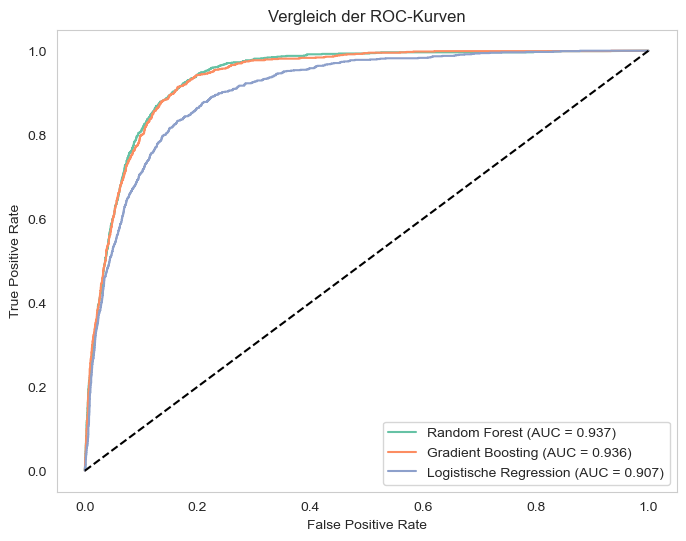

In [26]:
# ROC-Kurven erstellen
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf2)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)

# ROC-Kurven plotten
plt.figure(figsize=(8,6))

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf2):.3f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_pred_proba_gb):.3f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistische Regression (AUC = {roc_auc_score(y_test, y_pred_proba_logreg):.3f})')

# Diagonale Linie (zufälliges Raten)
plt.plot([0, 1], [0, 1], 'k--')

# Achsenbeschriftungen und Titel
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Vergleich der ROC-Kurven')

# Legende
plt.legend(loc='lower right')

plt.grid()
plt.show()


##### Zusammenfassung
Basierend auf dem Modellvergleich erzielte das feinabgestimmte Random Forest Modell die besten Ergebnisse:  
Es erreichte den höchsten F1-Score für die positive Klasse (0.5841), den besten ROC-AUC-Wert (0.9371) sowie die höchste Accuracy (0.9098).

Da das Geschäftsinteresse darauf abzielt, möglichst viele tatsächliche Abschlüsse korrekt zu identifizieren und unnötige Kundenkontakte zu vermeiden, wurde Random Forest als finales Modell ausgewählt.  
Die endgültigen Vorhersagen sind in der Variablen `y_pred_rf2` gespeichert.

### 8. Weiterführende Überlegungen

**Um die Prognose weiter zu verbessern, wären zusätzliche Merkmale hilfreich, die aktuell nicht im Datensatz enthalten sind:**

- **Einkommenshöhe:** Das konkrete Einkommen des Kunden, da es mit Spar- und Anlageverhalten korreliert.
- **Region oder Wohnort:** Stadt oder Region des Kunden (z.B. ländlich vs. städtisch), um sozioökonomische Faktoren zu berücksichtigen.
- **Bestehende Spar- oder Anlageprodukte:** Informationen darüber, ob der Kunde bereits andere Sparformen oder Investmentprodukte nutzt (z.B. Sparkonten, Investmentfonds). Kunden mit einer Affinität zu risikoarmen Produkten sind besonders vielversprechend für Festgeld Angebote.

Diese zusätzlichen Variablen könnten helfen, das Abschlussverhalten noch genauer zu modellieren.

**Die eingesetzte Methodik (Feature Engineering, Klassifikationsmodelle, Modellvergleich) ist flexibel und lässt sich auf weitere Anwendungsfälle übertragen, etwa:**

- **Churn Prediction:** Prognose, ob Kunden die Bank verlassen könnten.
- **Risikomanagement:** Einschätzung der Ausfallwahrscheinlichkeit bei Krediten.

**Wie müsste die Problemstellung angepasst werden?**
- Die Zielvariable müsste je nach Anwendung neu definiert werden (z.B. kündigung = 1 / bleibt = 0).
- Eventuell müssten auch andere oder zusätzliche Merkmale ausgewählt oder neu erstellt werden.
- Die Optimierung der Modelle könnte sich je nach Geschäftsziel stärker auf Recall oder Precision ausrichten.